## Get identifiers for 16s

In [ ]:
# This line imports the Bio.Entrez module, and makes it available
# as 'Entrez'.
from Bio import Entrez

# The line below imports the Bio.SeqIO module, which allows reading
# and writing of common bioinformatics sequence formats.
from Bio import SeqIO

# Create a new directory (if needed) for output/downloads
import os
outdir = "./ncbi_downloads"
os.makedirs(outdir, exist_ok=True)

# This line sets the variable 'Entrez.email' to the specified
# email address. You should substitute your own address for the
# example address provided below. Please do not provide a
# fake name.
Entrez.email = "evankomp@uw.edu"

# This line sets the name of the tool that is making the queries
Entrez.tool = "learn2therm"

In [ ]:
handle = Entrez.esearch(db="nucleotide", term="33175[BioProject] OR 33317[BioProject]", retmax=26980)

# This line converts the returned information from NCBI into a form we
# can use, as before.
idlist = Entrez.read(handle)

In [ ]:
idlist

In [ ]:
len(idlist['IdList'])

## retrieve sequences

In [ ]:
handle = Entrez.efetch(db="nucleotide", rettype="gb", retmode="text",
    id=idlist['IdList'])


In [ ]:
records = SeqIO.parse(handle, 'genbank')

In [ ]:
total = 0
for record in records:
    total += 1
print(total)

In [ ]:
dir(record)

In [ ]:
record.annotations

In [ ]:
dir(record.features[0])

In [ ]:
record.features[0].type

In [ ]:
record.features[0].qualifiers

In [ ]:
record.seq

In [ ]:
dir(record.seq)
    

## load data sources and have a look

In [ ]:
import pandas as pd

In [ ]:
seq_16s = pd.read_csv('../tmp/16s.csv', index_col=0)

In [ ]:
seq_16s['taxid'].value_counts()

We have multiple 16s for some taxa

In [ ]:
sequences = seq_16s[seq_16s['taxid'] == 1406]['16s_seq']

In [ ]:
sequences.apply(len)

In [ ]:
from Bio.Blast.Applications import NcbiblastnCommandline
from io import StringIO
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# Create two sequence files
seq_records = []
for ind, s in sequences.items():
    seq_records.append(SeqRecord(Seq(s),
                   id=str(ind)))
SeqIO.write(seq_records, "./tmp/seqs.fasta", "fasta")

# Run BLAST and parse the output as XML
output = NcbiblastnCommandline(query="./tmp/seqs.fasta", subject="./tmp/seqs.fasta", outfmt=5)()[0]
blast_result_records = NCBIXML.parse(StringIO(output))

# Print some information on the result
ids = []
for record in blast_result_records:
    for alignment in record.alignments:
        for hsp in alignment.hsps:
            print('****Alignment****')
            print('sequence:', alignment.title)
            print('length:', alignment.length)
            id_ = 2*hsp.identities/(record.query_length + alignment.length)
            print('id', id_)
            ids.append(id_)

In [ ]:
min(ids)

The duplicates don't mutch matter. drop them.

In [ ]:
seq_16s['len'] = seq_16s['16s_seq'].apply(len)

In [ ]:
seq_16s['len'].describe()

In [ ]:
seq_16s = seq_16s.sort_values('len', ascending=False)

In [ ]:
seq_16s = seq_16s.drop_duplicates(subset='taxid', keep='first')

In [ ]:
len(seq_16s)

In [ ]:
ogts = pd.read_csv('../tmp/ogt', index_col=0)

In [ ]:
ogts['temperature'].plot.hist()

In [ ]:
ogts.groupby('taxid').std()['temperature'].plot.hist()

In [ ]:
groups = ogts.groupby('taxid')

for _, df_ in groups:
    if len(df_) > 1:
        print(df_['temperature'].min(), df_['temperature'].max(), df_['temperature'].max() - df_['temperature'].min())

take the mean

In [ ]:
ogts = ogts.groupby('taxid').mean().reset_index()

In [ ]:
df = ogts.merge(seq_16s, on='taxid', how='inner')

In [ ]:
df[df['taxid']==1609559]

In [ ]:
df[df['taxid']==1609559].iloc[0]['16s_seq']

In [ ]:
len("""ATTCCGGTTGATCCTGCCGGAGGCCACTGCTATGGGGGTCCGACTAAGCCATGCGAGTCAAGGGGGCGTC
CCTTCTGGGACGCCACCGGCGGACGGCTCAGTAACACGTCGGTAACCTACCCTCGGGAGGGGGATAACCC
CGGGAAACTGGGGCTAATCCCCCATAGGCCTGGGGTACTGGAAGGTCCCCAGGCCGAAAGGGGACCGTAA
GGTCCCGCCCGAGGATGGGCCGGCGGCCGATTAGGTAGTTGGTGGGGTAACGGCCCACCAAGCCGAAGAT
CGGTACGGGCCGTGAGAGCGGGAGCCCGGAGATGGACACTGAGACACGGGTCCAGGCCCTACGGGGCGCA
GCAGGCGCGAAACCTCCGCAATGCGGGAAACCGCGACGGGGGGACCCCCAGTGCCGTGCCTCTGGCACGG
CTTTTCCGGAGTGTAAAAAGCTCCGGGAATAAGGGCTGGGCAAGGCCGGTGGCAGCCGCCGCGGTAATAC
CGGCGGCCCGAGTGGTGGCCACTATTATTGGGCCTAAAGCGGCCGTAGCCGGGCCCGTAAGTCCCTGGCG
AAATCCCACGGCTCAACCGTGGGGCTCGCTGGGGATACTGCGGGCCTTGGGACCGGGAGAGGCCGGGGGT
ACCCCCGGGGTAGGGGTGAAATCCTATAATCCCGGGGGGACCGCCAGTGGCGAAGGCGCCCGGCTGGAAC
GGGTCCGACGGTGAGGGCCGAAGGCCAGGGGAGCGAACCGGATTAGATACCCGGGTAGTCCTGGCTGTAA
AGGATGCGGGCTAGGTGTCGGGCGAGCTTCGAGCTCGCCCGGTGCCGTAGGGAAGCCGTTAAGCCCGCCG
CCTGGGGAGTACGGCCGCAAGGCTGAAACTTAAAGGAATTGGCGGGGGAGCACTACAAGGGGTGGAGCGT
GCGGTTTAATTGGATTCAACGCCGGGAACCTCACCGGGGGCGACGGCAGGATGAAGGCCAGGCTGAAGGT
CTTGCCGGACGCGCCGAGAGGAGGTGCATGGCCGCCGTCAGCTCGTACCGTGAGGCGTCCACTTAAGTGT
GGTAACGAGCGAGACCCGCGCCCCCAGTTGCCAGTCCCTCCCGCTTGGGAGGGAGGCACTCTGGGGGGAC
TGCCGGCGATAAGCCGGAGGAAGGGGCGGGCGACGGTAGGTCAGTATGCCCCGAAACCCCCGGGCTACAC
GCGCGCTACAATGGGCGGGACAATGGGACCCGACCCCGAAAGGGGAAGGGAATCCCCTAAACCCGCCCTC
AGTTCGGATCGCGGGCTGCAACTCGCCCGCGTGAAGCTGGAATCCCTAGTACCCGCGCGTCATCATCGCG
CGGCGAATACGTCCCTGCTCCTTGCACACACCGCCCGTCACTCCACCCGAGCGGGGCCCGGGTGAGGCTC
GATCTCCTTCGGGAGGTCGGGTCGAGCCCGGGCTCCGTGAGGGGGGAGAAGTCGTAACAAGGTAGCCGTA
GGGGAACCTACGGCTCGATCACCTCCT""")

blast online is happy with the 16s we have and the one I found when looking up the taxa

## Read uniprot data for ecoli

In [ ]:
import learn2therm.io
from Bio import SeqIO
import numpy as np
import pandas as pd

In [ ]:
records = learn2therm.io.seq_io_gnuzipped('./uniprot_ecoli.xml.gz', filetype='uniprot-xml')

In [ ]:
record = next(records)

In [ ]:
record.annotations

In [ ]:
print(record.annotations.keys())

In [ ]:
record.annotations['taxonomy']

In [ ]:
record.annotations['organism']

In [ ]:
record.annotations['type']

In [ ]:
record.dbxrefs

In [ ]:
def get_all_dbx(record):
    return [k.split(':')[0] for k in record.dbxrefs]

In [ ]:
records = learn2therm.io.seq_io_gnuzipped('./uniprot_ecoli.xml.gz', filetype='uniprot-xml')
all_unique_ref = []
total_recs = 0
for record in records:
    all_unique_ref.extend(list(np.unique(get_all_dbx(record))))
    total_recs +=1
    if total_recs % 50000 == 0:
        print(total_recs)

all_unique_ref = pd.Series(data=all_unique_ref)


In [ ]:
percent_have_ref = all_unique_ref.value_counts()/total_recs
with pd.option_context('display.max_rows', 70):
    print(percent_have_ref)

looks like every single protein has taxid - lets see if we can differentiate between strains

In [ ]:
def get_taxids(record):
    found = 0
    taxids = []
    for dbxref in record.dbxrefs:
        if dbxref.startswith('NCBI Taxonomy:'):
            found += 1
            taxids.extend(dbxref.split(':')[1:])
    if found > 1:
        print('found more than one taxid for record', record.id)
        print(taxids)
    return taxids

In [ ]:
records = learn2therm.io.seq_io_gnuzipped('./uniprot_ecoli.xml.gz', filetype='uniprot-xml')
all_taxids = []
total_recs = 0
for record in records:
    all_taxids.append(get_taxids(record))
    total_recs +=1
    if total_recs % 50000 == 0:
        print(total_recs)

In [ ]:
all_taxids = pd.Series(data=all_taxids)

In [ ]:
all_taxids.apply(len).value_counts()

taxid is parent taxid. Can we differentiate between strains by organism name?

In [ ]:
records = learn2therm.io.seq_io_gnuzipped('./uniprot_ecoli.xml.gz', filetype='uniprot-xml')
names = []
total_recs = 0
for record in records:
    names.append(record.annotations['organism'])
    total_recs +=1
    if total_recs % 50000 == 0:
        print(total_recs)

In [ ]:
pd.value_counts(names)

All names come back the same, regardless of strain. Can we use accessions?

In [ ]:
record.dbxrefs

## Load a single proteome

can we first parse proteome metadata to help sift proteins?

In [ ]:
from Bio import SeqIO
import learn2therm.io
import json

In [ ]:
f = open('./uniprot_1prot.json', 'r')
records = json.load(f)
f.close()


In [ ]:
record = records['results'][0]

In [ ]:
record

In [ ]:
record.keys()

## Use pan proteom membership to filter proteins

In [ ]:
import learn2therm.io
from Bio import SeqIO
import numpy as np
import pandas as pd

In [ ]:
records = learn2therm.io.seq_io_gnuzipped('./uniprot_ecoli.xml.gz', filetype='uniprot-xml')

In [ ]:
proteome_memership = pd.read_csv('./PPMembership.txt', delim_whitespace=True)

In [ ]:
proteome_memership = proteome_memership[~(proteome_memership['PPMember'] == proteome_memership['PP'])]

In [ ]:
proteome_memership

In [ ]:
def get_proteomes(record):
    proteomes = []
    for dbxref in record.dbxrefs:
        if dbxref.startswith('Proteomes:'):
            proteomes.append(dbxref.split(':')[1])
    return np.array(proteomes)

def select_best_proteome(proteomes):
    if len(proteomes) == 0:
        return None
    elif len(proteomes) == 1:
        return proteomes[0]
    else:
        non_redundant_proteomes = proteomes[~np.isin(proteomes, proteome_memership['PPMember'])]
        if len(non_redundant_proteomes) >= 1:
            num_pps = np.isin(non_redundant_proteomes, proteome_memership['PP']).sum()
            if num_pps == 1:
                return non_redundant_proteomes[np.isin(non_redundant_proteomes, proteome_memership['PP'])][0]
            elif num_pps > 1:
                raise ValueError(f"Could not find a single proteome: {proteomes}")
            else:
                return non_redundant_proteomes[0]
        else:
            return proteomes[0]

In [ ]:
records = learn2therm.io.seq_io_gnuzipped('./uniprot_ecoli.xml.gz', filetype='uniprot-xml')
proteome_list = []
total = 0
for record in records:
    proteome_list.append(select_best_proteome(get_proteomes(record)))
    total += 1
    if total % 50000 == 0:
        print(total)

In [ ]:
pd.value_counts(proteome_list)

In [ ]:
proteomes = get_proteomes(record)
proteomes

In [ ]:
np.isin(proteomes, proteome_memership['PP']).sum()

In [ ]:
np.isin(proteomes, proteome_memership['PPMember']).sum()

In [ ]:
'UP000315125' in proteome_memership['PP']

In [ ]:
proteomes[~np.isin(proteomes, proteome_memership['PPMember'])]

## Develop parsing of proteome metadata first

In [1]:
import json
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import pprint
import numpy as np

In [2]:
# load proteome file
with gzip.open('./uniprot_proteoms.json.gz', 'rt') as f:
    proteomes = json.load(f)
proteomes = proteomes['results']

In [3]:
len(proteomes)

500354

what proteome types do we have

In [4]:
# loop through proteomes get the qualifiers of proteome, eg reference or pan
proteome_qualifiers = [p['proteomeType'] for p in proteomes]
pd.value_counts(proteome_qualifiers)

Redundant proteome                       314666
Other proteome                           140874
Representative proteome                   21925
Excluded                                  21889
Reference and representative proteome       811
Reference proteome                          189
dtype: int64

Parse as DF so we can do some groupbys

In [47]:
def do_one_proteome(proteome):
    try:
        out = {}
        out['pid'] = proteome['id']
        try:
            lowest_lineage = proteome['taxonLineage'][-1]
            if lowest_lineage['rank'] == 'species':
                out['species_taxid'] = lowest_lineage['taxonId']
            else:
                raise KeyError()
        except KeyError:
            out['species_taxid'] = proteome['taxonomy']['taxonId']
        
        out['strain_taxid'] = proteome['taxonomy']['taxonId']
        out['qualifier'] = proteome['proteomeType']
        out['completeness'] = proteome['proteomeCompletenessReport']['cpdReport']['status']
        out['num_proteins'] = sum([c['proteinCount'] for c in proteome['components']])
    except:
        pprint.pprint(proteome)
        raise
    return out

In [48]:
proteome_data = pd.DataFrame([do_one_proteome(p) for p in proteomes])

For Eg. ecoli, how many representative proteomes do we have

In [49]:
proteome_data[proteome_data['species_taxid'] == 562]

,pid,species_taxid,strain_taxid,qualifier,completeness,num_proteins
0,UP000000625,562,83333,Reference and representative proteome,Standard,4403
1236,UP000000558,562,83334,Reference and representative proteome,Standard,5062
1292,UP000000746,562,585055,Reference proteome,Standard,4797
1293,UP000000747,562,585035,Reference proteome,Standard,4805
1397,UP000001123,562,331112,Reference proteome,Close to standard (low value),4308
...,...,...,...,...,...,...
500309,UP000885376,562,562,Redundant proteome,Close to standard (high value),5122
500310,UP000885377,562,562,Redundant proteome,Standard,4947
500321,UP000885393,562,562,Redundant proteome,Standard,5018
500327,UP000885399,562,562,Redundant proteome,Standard,4854


more than one...

Proposed strategy:
group by strain, find best proteome in order of: 
1. qualifier as reference and representative
2. reference
3. representative with the most proteins
4. remove redundant, and excluded proteomes, whichever is left and has the most proteins

In [65]:
def get_best_proteome_from_group(dataframe):
    """Find best proteome among a group of proteomes with the same species and or strain
    
    Select best proteome with priority:
    1. qualifier as 'Reference and representative proteome'
    2. qualifier as reference 'Reference proteome'
    3. qualifier as reference 'Representative proteome', most proteins
    4. remove 'Redundant proteome', and 'Excluded', whichever is left and has the most proteins is returned
    """
    if len(dataframe) == 1:
        return dataframe
    else:
        # get any 'Reference and representative proteome'
        ref_rep = dataframe[dataframe['qualifier'] == 'Reference and representative proteome']
        if len(ref_rep) == 1:
            return ref_rep
        elif len(ref_rep) > 1:
            return pd.DataFrame(ref_rep.iloc[np.argmax(ref_rep['num_proteins'])]).T 
        
        # now check for Reference proteome
        ref = dataframe[dataframe['qualifier'] == 'Reference proteome']
        if len(ref) == 1:
            return ref
        elif len(ref) > 1:
            return pd.DataFrame(ref.iloc[np.argmax(ref['num_proteins'])]).T
        
        # now check for Representative proteome
        rep = dataframe[dataframe['qualifier'] == 'Representative proteome']
        # get the one with the most proteins
        if len(rep) >= 1:
            return pd.DataFrame(rep.iloc[np.argmax(rep['num_proteins'])]).T
        
        # otherwise, remove 'Redundant proteome', and 'Excluded', whichever is left and has the most proteins is returned
        non_redun = dataframe[dataframe['qualifier'] != 'Redundant proteome']
        non_redun = non_redun[non_redun['qualifier'] != 'Excluded']
        if len(non_redun) == 1:
            return non_redun
        elif len(non_redun) > 1:
            return pd.DataFrame(non_redun.iloc[np.argmax(non_redun['num_proteins'])]).T


In [51]:
strain_groups = proteome_data.groupby('strain_taxid')

In [52]:
len(strain_groups)

117236

In [53]:
strain_aggregated_dfs = []
completed = 0
for i, group in strain_groups:
    best_proteome = get_best_proteome_from_group(group)
    strain_aggregated_dfs.append(best_proteome)
    completed += 1
    if completed % 50000 == 0:
        print(completed)

50000
100000


In [61]:
strain_aggregated_df = pd.concat(strain_aggregated_dfs)

In [64]:
len(strain_aggregated_df['strain_taxid'].unique())/len(strain_aggregated_df)

1.0

In [85]:
# now group by species and select the largest proteome
species_groups = strain_aggregated_df.groupby('species_taxid')
species_aggregated_dfs = []
for i, group in species_groups:
    best_proteome = get_best_proteome_from_group(group)
    species_aggregated_dfs.append(best_proteome)

In [86]:
species_aggregated_df = pd.concat(species_aggregated_dfs)

<AxesSubplot: ylabel='Frequency'>

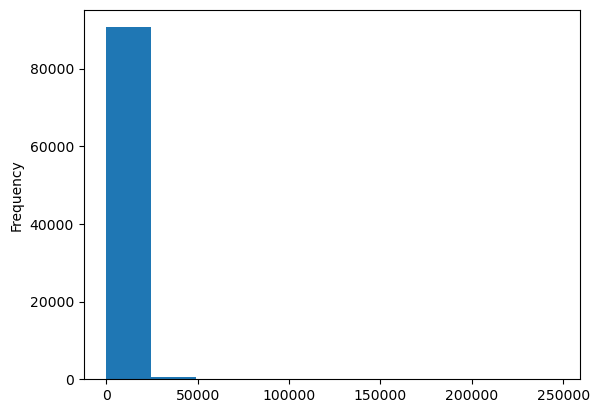

In [88]:
species_aggregated_df['num_proteins'].plot.hist()

In [92]:
species_aggregated_df.sort_values(by='num_proteins', ascending=False)

,pid,species_taxid,strain_taxid,qualifier,completeness,num_proteins
21193,UP000499080,182803,182803,Representative proteome,Outlier (high value),246578
3018,UP000015105,37682,200361,Representative proteome,Outlier (high value),214162
275899,UP000324705,4571,4567,Excluded,Outlier (high value),189776
3507,UP000019116,4565,4565,Representative proteome,Outlier (high value),130673
18944,UP000265520,97028,97028,Representative proteome,Outlier (high value),116147
...,...,...,...,...,...,...
112132,UP000203315,1345661,1345661,Other proteome,Standard,1
89721,UP000207743,1345662,1345662,Other proteome,Standard,1
56227,UP000242382,83440,83440,Other proteome,Outlier (low value),1
26596,UP000117861,467337,467337,Other proteome,Standard,1


In [93]:
proteome_data[proteome_data['species_taxid'] == 4571]

,pid,species_taxid,strain_taxid,qualifier,completeness,num_proteins
275899,UP000324705,4571,4567,Excluded,Outlier (high value),189776


## What dos data without a proteome look like?

In [69]:
import learn2therm.io
from Bio import SeqIO
import numpy as np
import pandas as pd
import pprint

In [81]:
records = learn2therm.io.seq_io_gnuzipped('./uniprot_ecoli.xml.gz', filetype='uniprot-xml')

In [68]:
def get_all_dbx(record):
    return [k.split(':')[0] for k in record.dbxrefs]

In [82]:
for record in records:
    if 'Proteomes' not in get_all_dbx(record):
        if len(record.annotations['proteinExistence']) > 1:
            assert False
        if 'inferred from homology' in record.annotations['proteinExistence']:
            continue
        else:
            pprint.pprint(record)
            break


SeqRecord(seq=Seq('MTVQTSKNPQVDIAEDNAFFPSEYSLSQYTSPVSDLDGVDYPKPYRGKHKILVI...YAS'), id='A0A8F9ARU2', name='A0A8F9ARU2_ECOLX', description='Protein/nucleic acid deglycase HchA', dbxrefs=['EC:3.1.2.-', 'EC:3.5.1.124', 'EMBL:CP080119', 'GO:GO:0005737', 'GO:GO:0006281', 'GO:GO:0008270', 'GO:GO:0016790', 'GO:GO:0016811', 'GO:GO:0030091', 'GO:GO:0036524', 'Gene3D:3.40.50.880', 'HAMAP:MF_01046', 'InterPro:IPR017283', 'InterPro:IPR029062', 'NCBI Taxonomy:562', 'PANTHER:PTHR48094', 'PANTHER:PTHR48094:SF20', 'PIRSF:PIRSF037798', 'SUPFAM:SSF52317', 'TrEMBL:A0A8F9ARU2', 'TrEMBL:A0A8F9ARU2_ECOLX'])


In [83]:
record.annotations

{'dataset': 'TrEMBL',
 'created': '2022-01-19',
 'modified': '2023-02-22',
 'version': 5,
 'accessions': ['A0A8F9ARU2'],
 'recommendedName_fullName': ['Protein/nucleic acid deglycase HchA'],
 'recommendedName_ecNumber': ['3.1.2.-', '3.5.1.124'],
 'alternativeName_fullName': ['Maillard deglycase'],
 'gene_name_primary': 'hchA',
 'gene_name_ORF': ['KZX76_21815'],
 'taxonomy': ['Bacteria',
  'Proteobacteria',
  'Gammaproteobacteria',
  'Enterobacterales',
  'Enterobacteriaceae',
  'Escherichia'],
 'organism': 'Escherichia coli',
 'references': [Reference(title='Fitness effect of CTX-M-15-encoding IncF plasmids on their native Escherichia coli ST131 H30Rx hosts.', ...)],
 'comment_function': ['Protein and nucleotide deglycase that catalyzes the deglycation of the Maillard adducts formed between amino groups of proteins or nucleotides and reactive carbonyl groups of glyoxals. Thus, functions as a protein deglycase that repairs methylglyoxal- and glyoxal-glycated proteins, and releases repai

In [84]:
record.dbxrefs

['EC:3.1.2.-',
 'EC:3.5.1.124',
 'EMBL:CP080119',
 'GO:GO:0005737',
 'GO:GO:0006281',
 'GO:GO:0008270',
 'GO:GO:0016790',
 'GO:GO:0016811',
 'GO:GO:0030091',
 'GO:GO:0036524',
 'Gene3D:3.40.50.880',
 'HAMAP:MF_01046',
 'InterPro:IPR017283',
 'InterPro:IPR029062',
 'NCBI Taxonomy:562',
 'PANTHER:PTHR48094',
 'PANTHER:PTHR48094:SF20',
 'PIRSF:PIRSF037798',
 'SUPFAM:SSF52317',
 'TrEMBL:A0A8F9ARU2',
 'TrEMBL:A0A8F9ARU2_ECOLX']

Some proteins simply do not have proteomes but were still observed

Likely, these should be kept and tracked.

## Read parquet files from proteins

In [ ]:
import pandas as pd

In [ ]:
pd.read_parquet('../data/proteins/uniprot_chunk_0.parquet')